[Predicting Visitor Purchases with BigQuery ML](https://www.cloudskillsboost.google/course_sessions/4974236/labs/387516)

#Przegląd

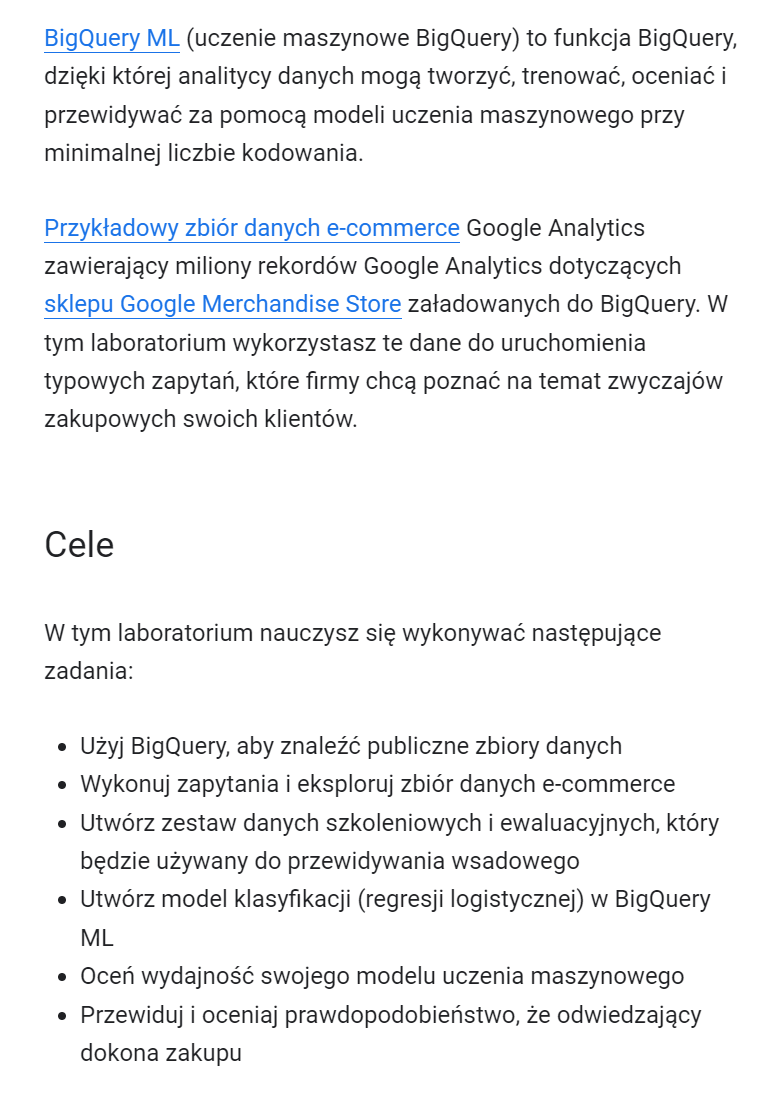

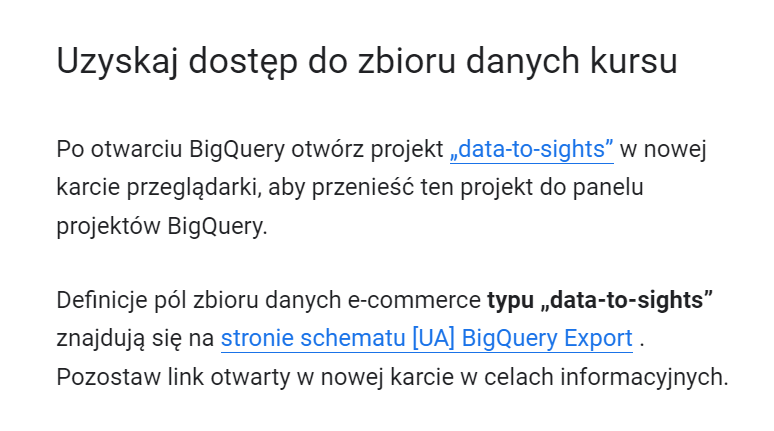

https://console.cloud.google.com/bigquery?p=data-to-insights&d=ecommerce&t=web_analytics&page=table

https://support.google.com/analytics/answer/3437719?hl=pl

#Zadanie 1. Zbadaj dane e-commerce

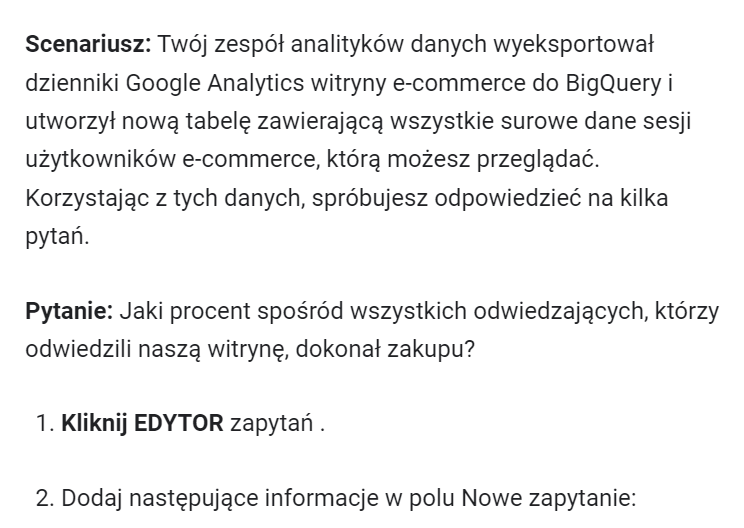

In [ ]:
%%bigquery

WITH visitors AS(
SELECT
COUNT(DISTINCT fullVisitorId) AS total_visitors
FROM `data-to-insights.ecommerce.web_analytics`
),
purchasers AS(
SELECT
COUNT(DISTINCT fullVisitorId) AS total_purchasers
FROM `data-to-insights.ecommerce.web_analytics`
WHERE totals.transactions IS NOT NULL
)
SELECT
  total_visitors,
  total_purchasers,
  total_purchasers / total_visitors AS conversion_rate
FROM visitors, purchasers

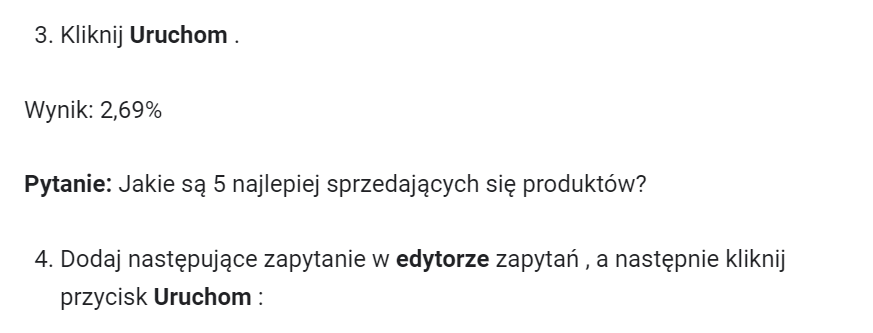

In [ ]:
%%bigquery

SELECT
  p.v2ProductName,
  p.v2ProductCategory,
  SUM(p.productQuantity) AS units_sold,
  ROUND(SUM(p.localProductRevenue/1000000),2) AS revenue
FROM `data-to-insights.ecommerce.web_analytics`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY 1, 2
ORDER BY revenue DESC
LIMIT 5;

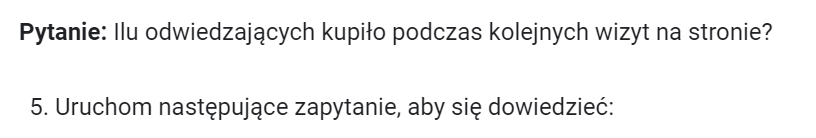

In [ ]:
%%bigquery

# visitors who bought on a return visit (could have bought on first as well
WITH all_visitor_stats AS (
SELECT
  fullvisitorid, # 741,721 unique visitors
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
SELECT
  COUNT(DISTINCT fullvisitorid) AS total_visitors,
  will_buy_on_return_visit
FROM all_visitor_stats
GROUP BY will_buy_on_return_visit

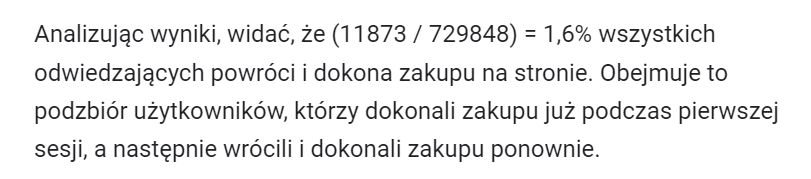

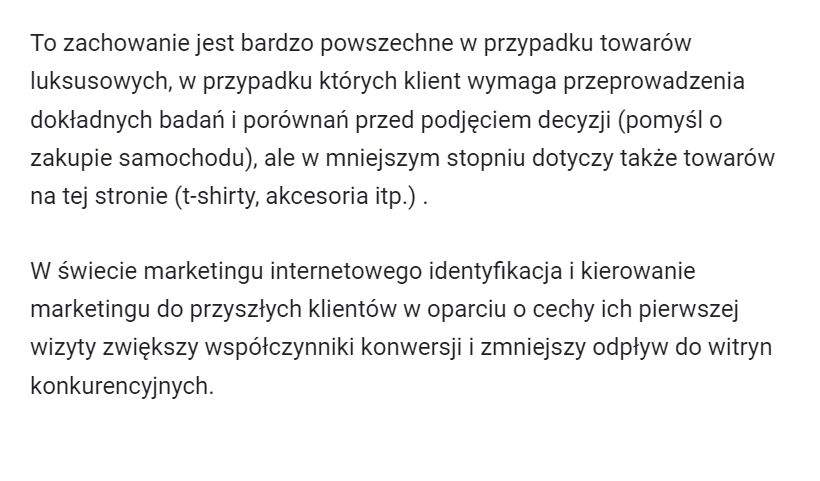

#Zadanie 2. Wybierz funkcje i utwórz zbiór danych szkoleniowych

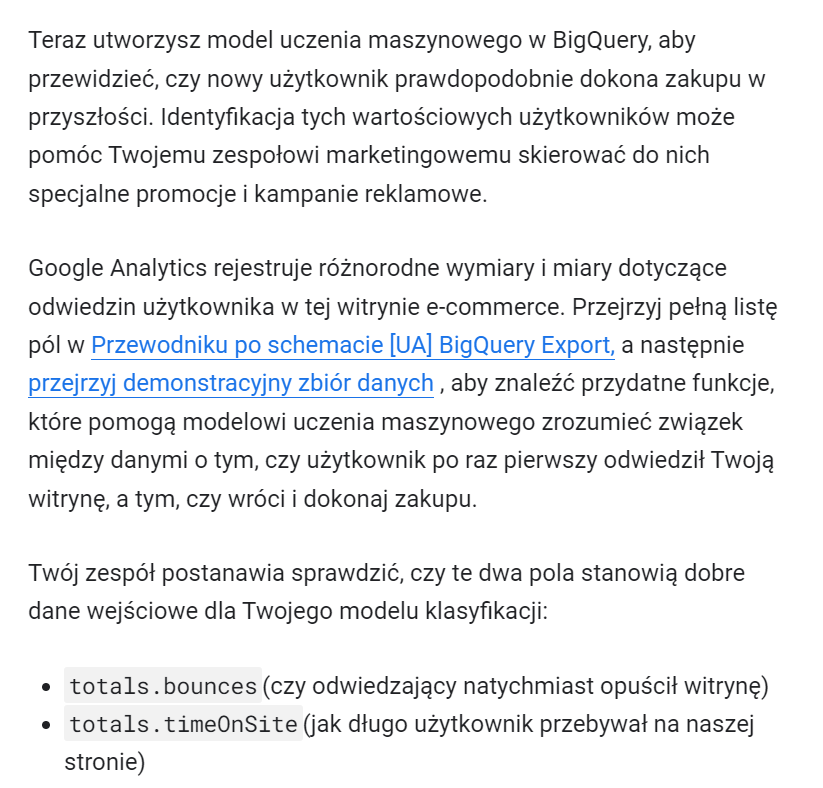

https://bigquery.cloud.google.com/table/data-to-insights:ecommerce.web_analytics?tab=preview

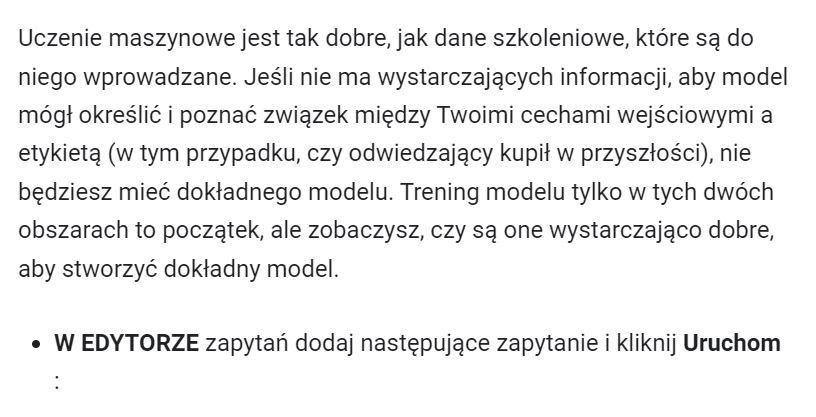

In [ ]:
%%bigquery

SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1)

  JOIN

  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)

  USING (fullVisitorId)
ORDER BY time_on_site DESC
LIMIT 10;

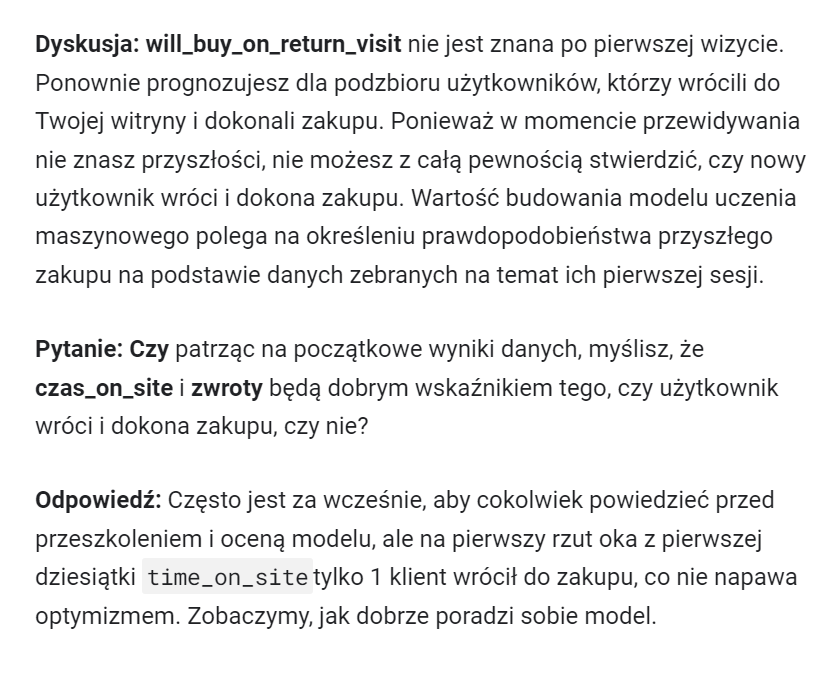

#Zadanie 3. Utwórz zbiór danych BigQuery do przechowywania modeli

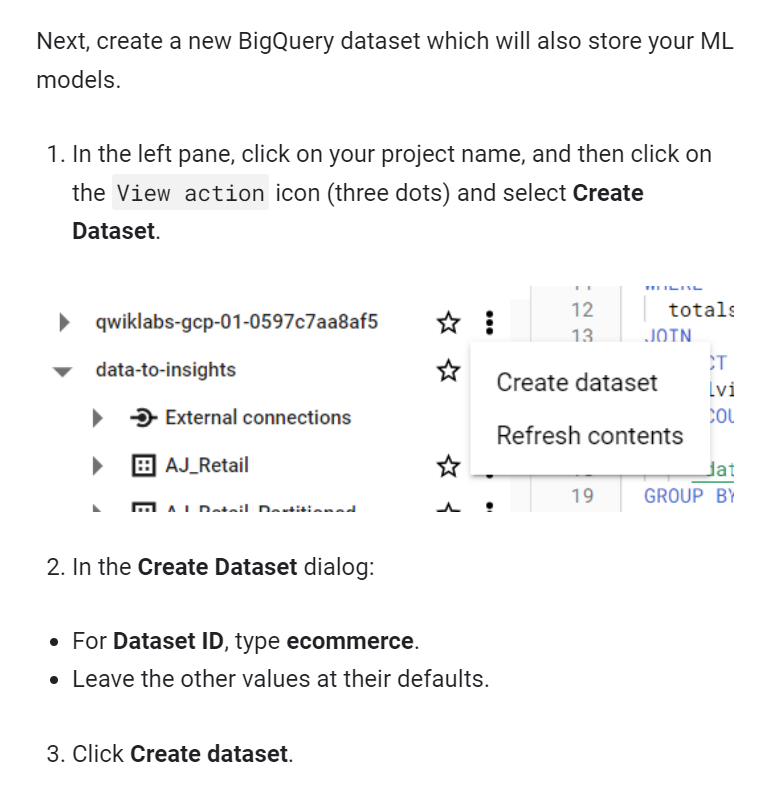

#Zadanie 4. Wybierz typ modelu BigQuery ML i określ opcje

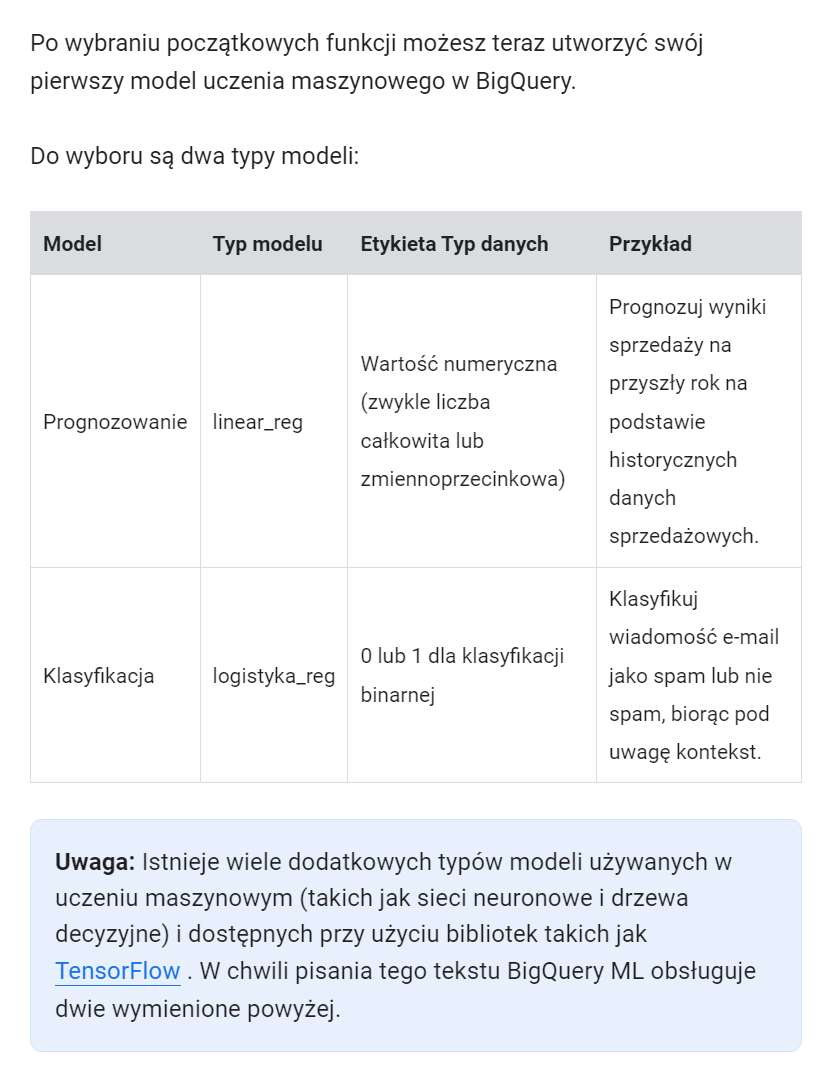

https://www.tensorflow.org/tutorials?hl=pl

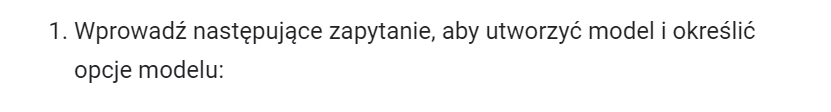

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `ecommerce.classification_model`
OPTIONS
(
model_type='logistic_reg',
labels = ['will_buy_on_return_visit']
)
AS

SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430') # train on first 9 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
;

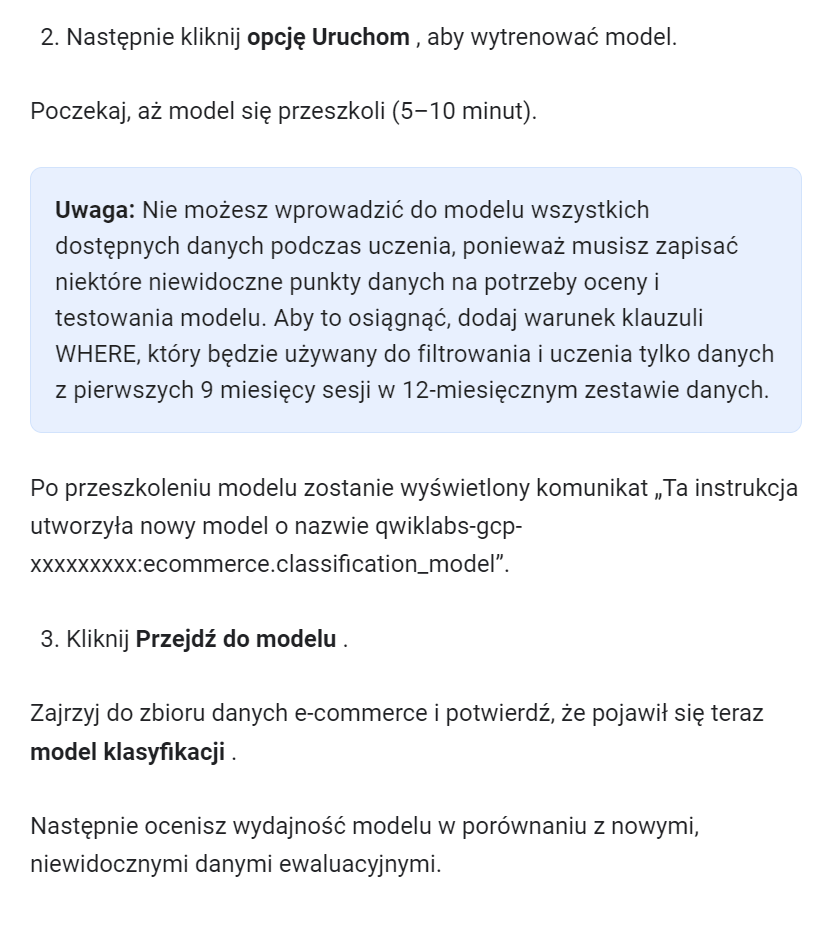

#Zadanie 5. Ocena wydajności modelu klasyfikacyjnego

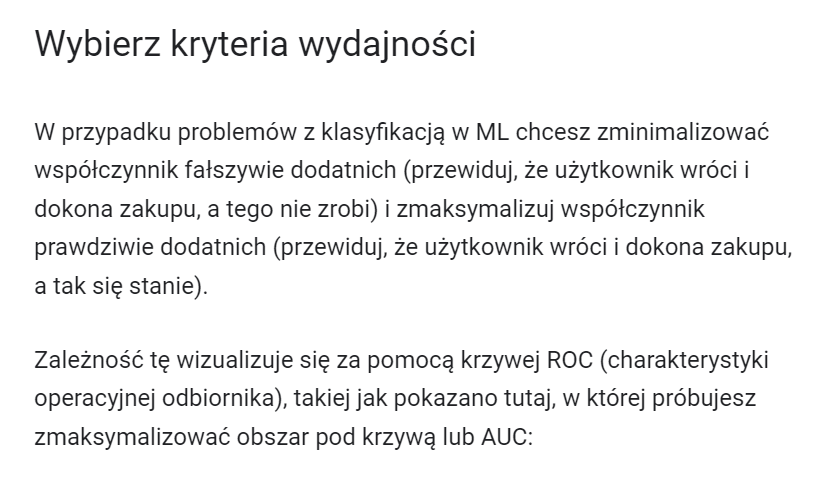

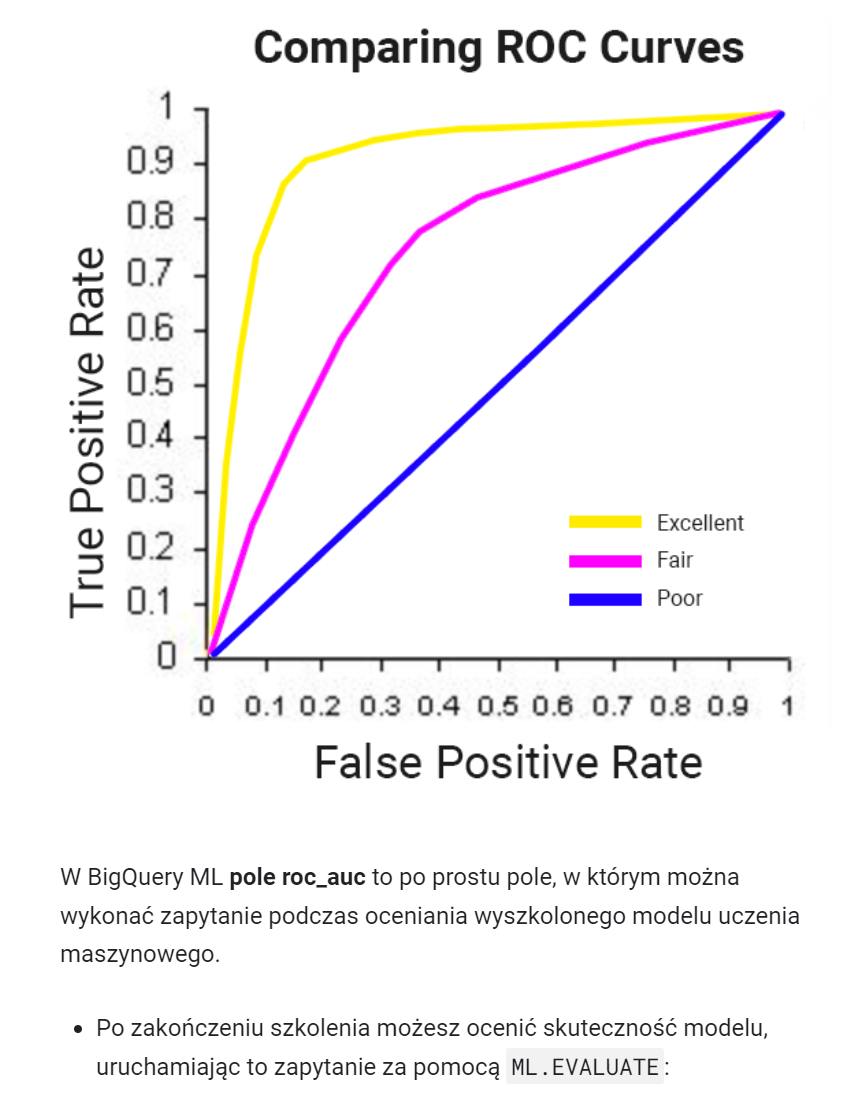

In [ ]:
%%bigquery

SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model,  (

SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630') # eval on 2 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
));

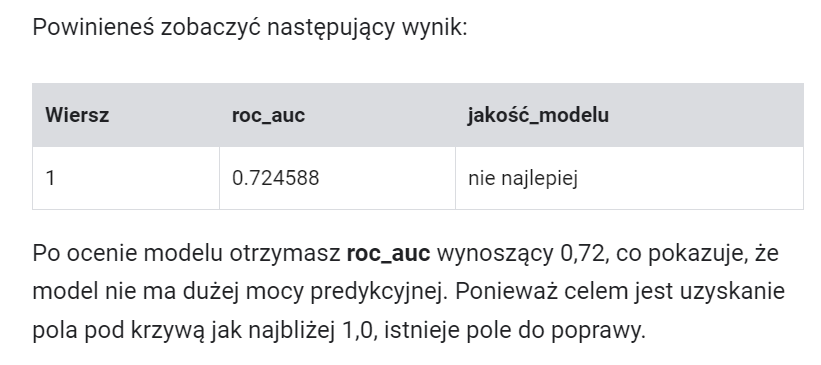

#Zadanie 6. Popraw wydajność modelu za pomocą inżynierii cech

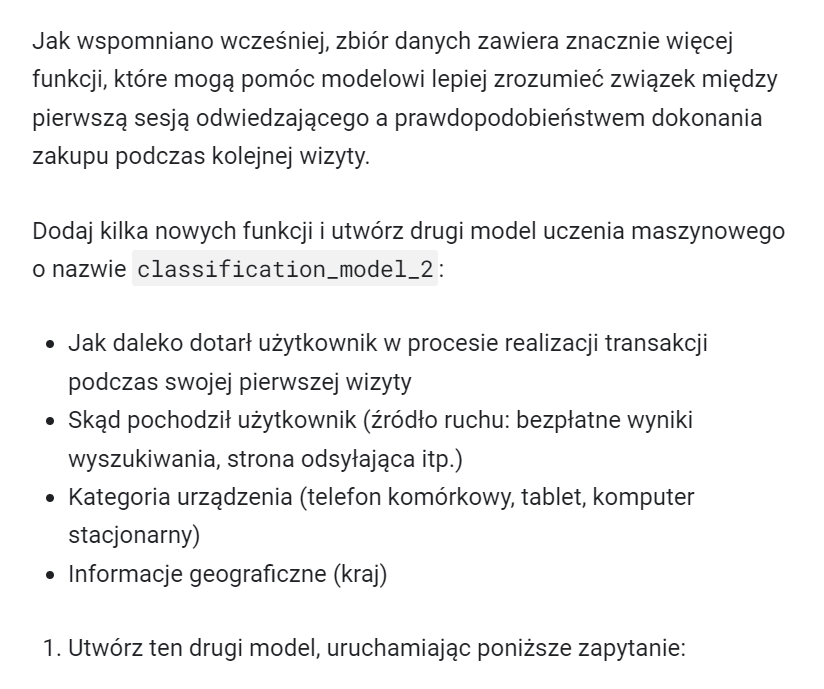

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `ecommerce.classification_model_2`
OPTIONS
  (model_type='logistic_reg',
  labels = ['will_buy_on_return_visit']) AS

WITH all_visitor_stats AS (

SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)

# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h

    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430' # train 9 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
);

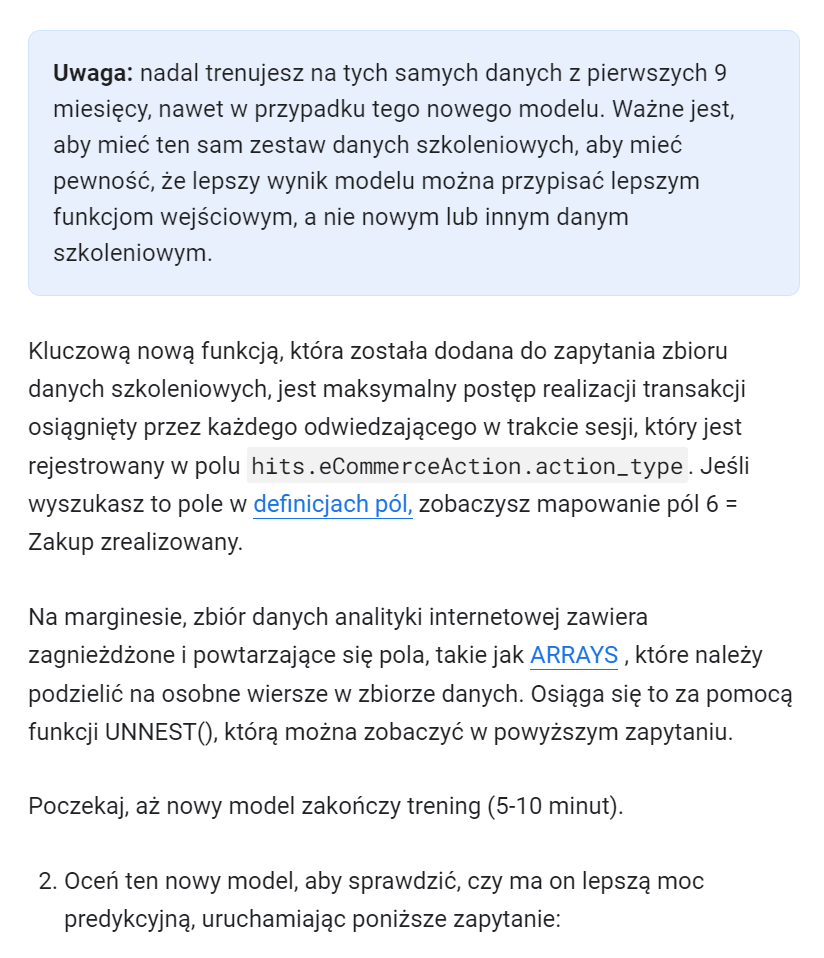

In [ ]:
%%bigquery

#standardSQL
SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_2,  (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

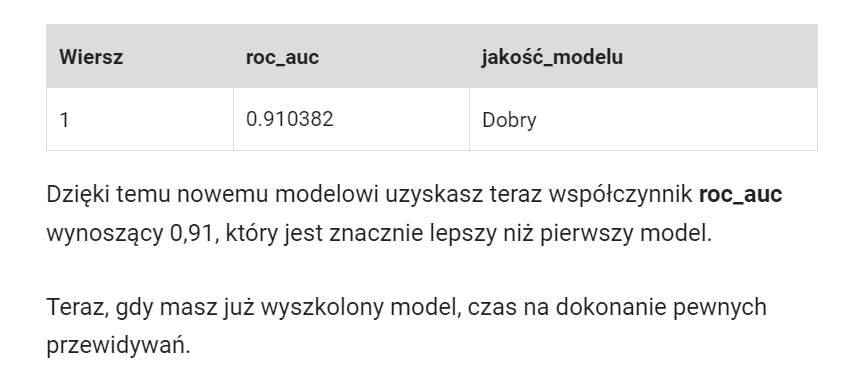

#Zadanie 7. Przewiduj, którzy nowi odwiedzający wrócą i dokonają zakupu

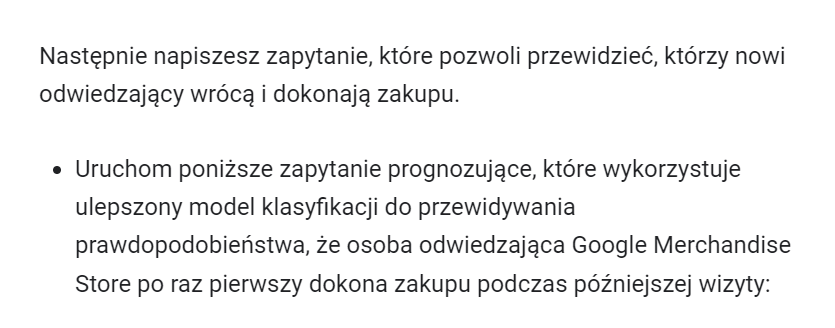

In [ ]:
%%bigquery

SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_2`,
   (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
)
ORDER BY
  predicted_will_buy_on_return_visit DESC;

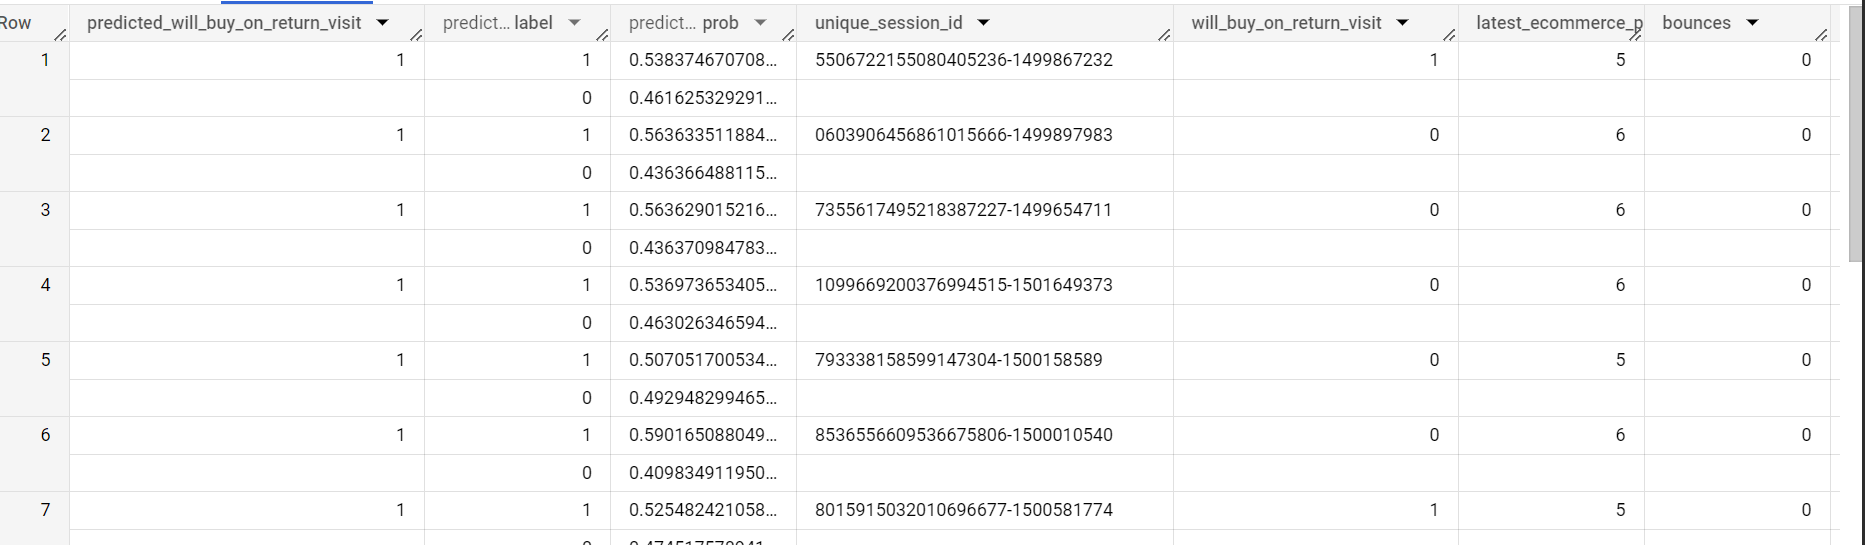

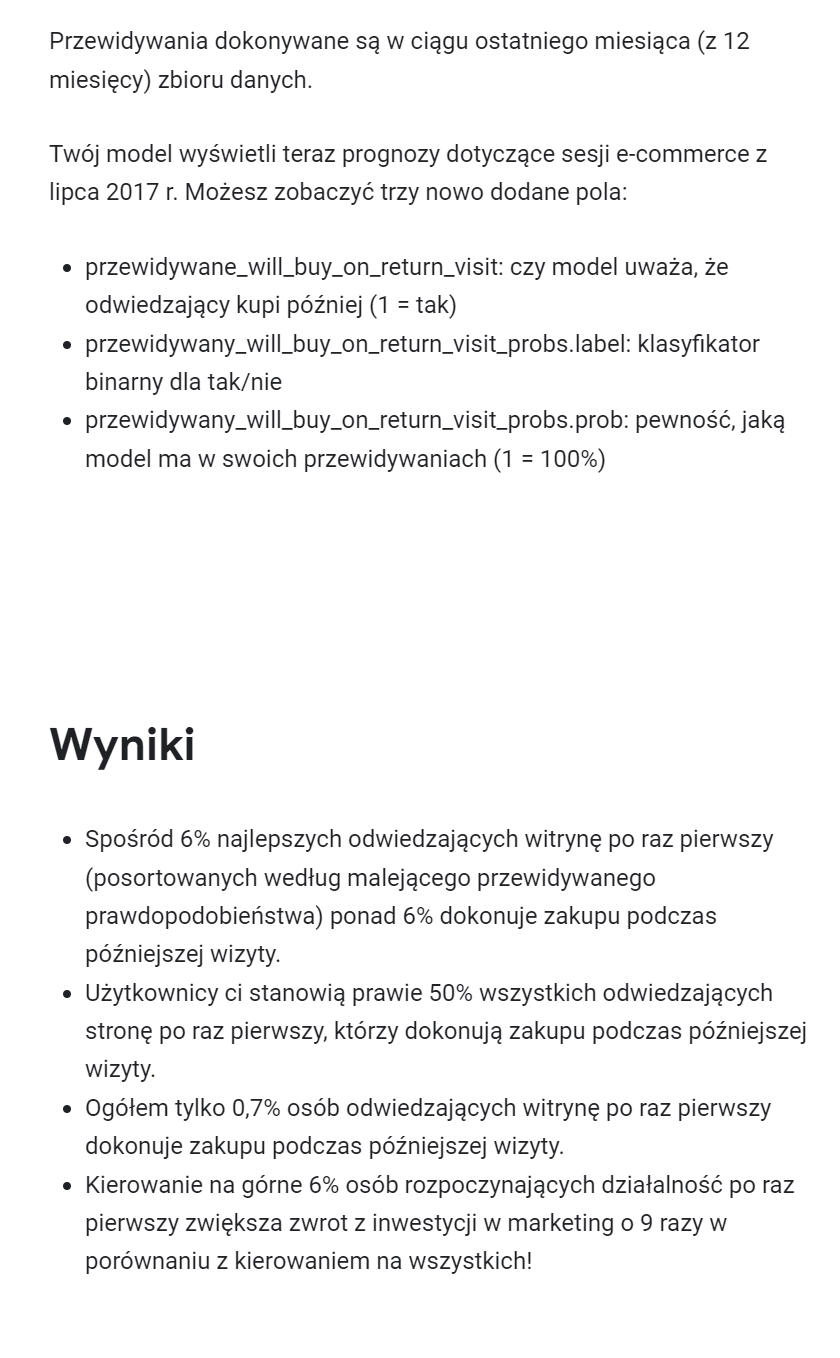

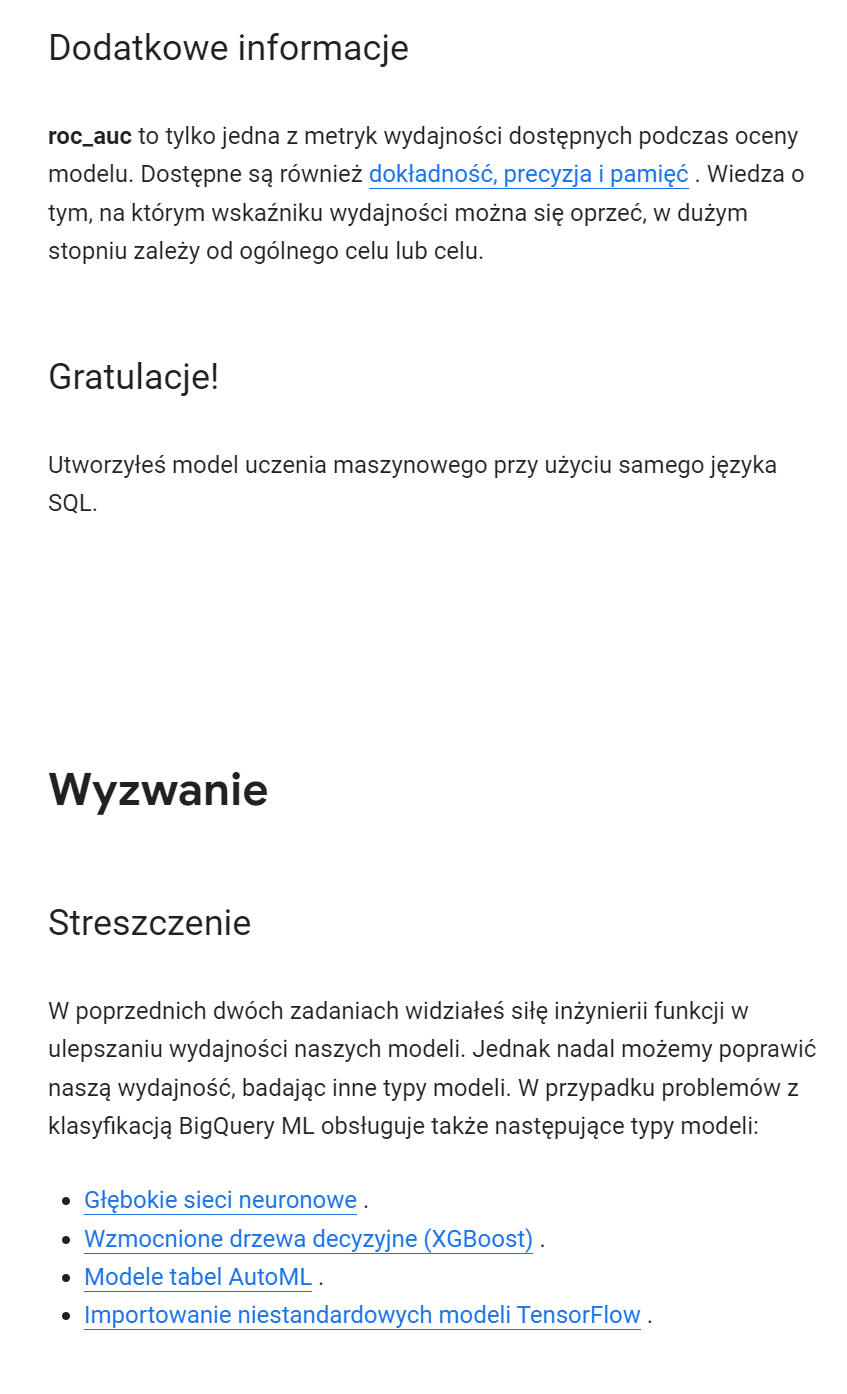

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-dnn-models

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-boosted-tree

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-automl

https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-tensorflow

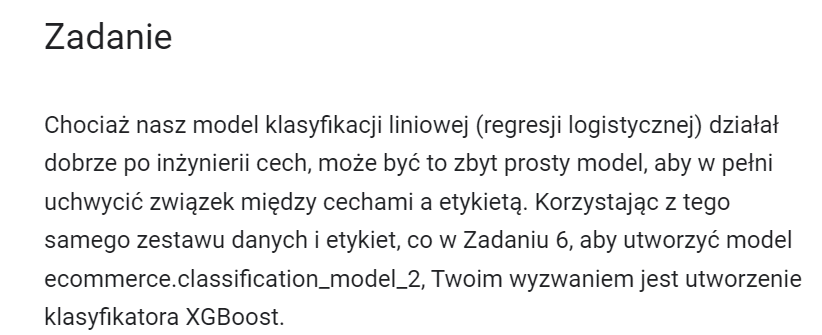

In [ ]:
# Note: Hint : Use following options for Boosted_Tree_Classifier:
1. L2_reg = 0.1
2. num_parallel_tree = 8
3. max_tree_depth = 10

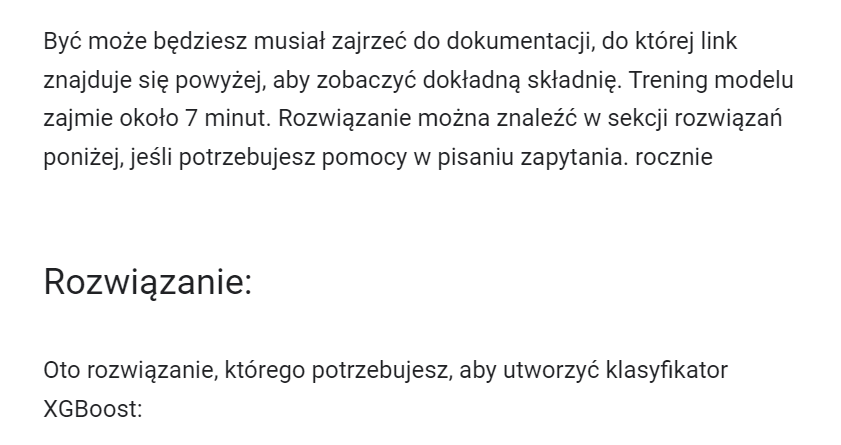

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `ecommerce.classification_model_3`
        OPTIONS
          (model_type='BOOSTED_TREE_CLASSIFIER',
          l2_reg = 0.1,
          num_parallel_tree = 8,
          max_tree_depth = 10,
          labels = ['will_buy_on_return_visit']
          ) AS

        WITH all_visitor_stats AS (
        SELECT
          fullvisitorid,
          IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
          FROM `data-to-insights.ecommerce.web_analytics`
          GROUP BY fullvisitorid
        )
        # add in new features
        SELECT * EXCEPT(unique_session_id) FROM (
          SELECT
              CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
              # labels
              will_buy_on_return_visit,
              MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
              # behavior on the site
              IFNULL(totals.bounces, 0) AS bounces,
              IFNULL(totals.timeOnSite, 0) AS time_on_site,
              totals.pageviews,
              # where the visitor came from
              trafficSource.source,
              trafficSource.medium,
              channelGrouping,
              # mobile or desktop
              device.deviceCategory,
              # geographic
              IFNULL(geoNetwork.country, "") AS country
          FROM `data-to-insights.ecommerce.web_analytics`,
             UNNEST(hits) AS h
            JOIN all_visitor_stats USING(fullvisitorid)
          WHERE 1=1
            # only predict for new visits
            AND totals.newVisits = 1
            AND date BETWEEN '20160801' AND '20170430' # train 9 months
          GROUP BY
          unique_session_id,
          will_buy_on_return_visit,
          bounces,
          time_on_site,
          totals.pageviews,
          trafficSource.source,
          trafficSource.medium,
          channelGrouping,
          device.deviceCategory,
          country
        );

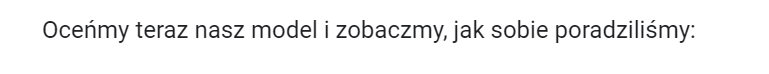

In [ ]:
%%bigquery

SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_3,  (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

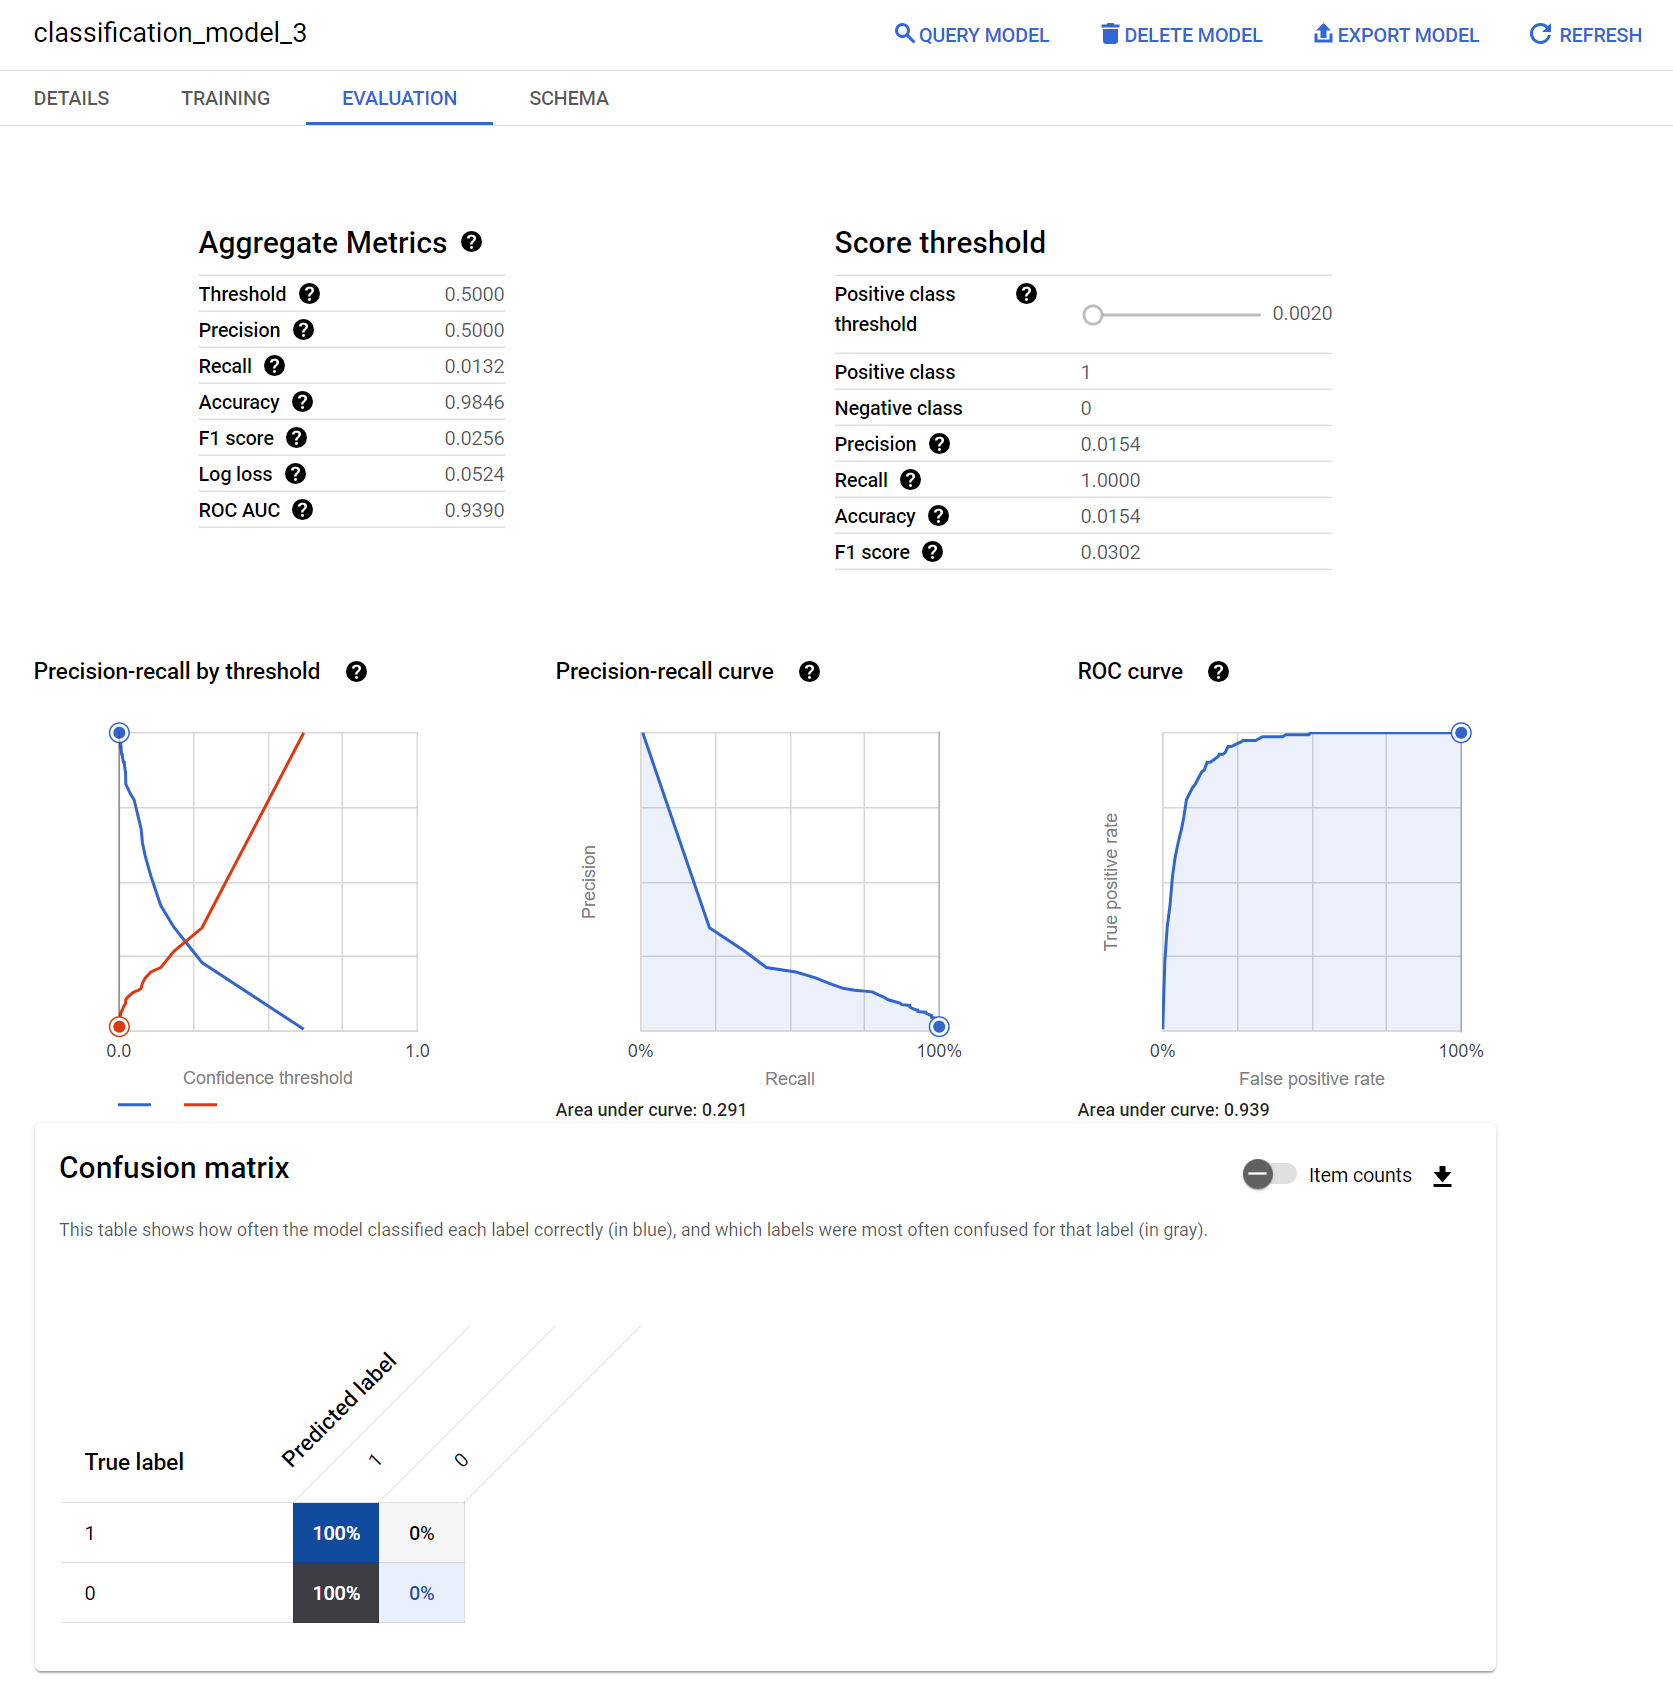

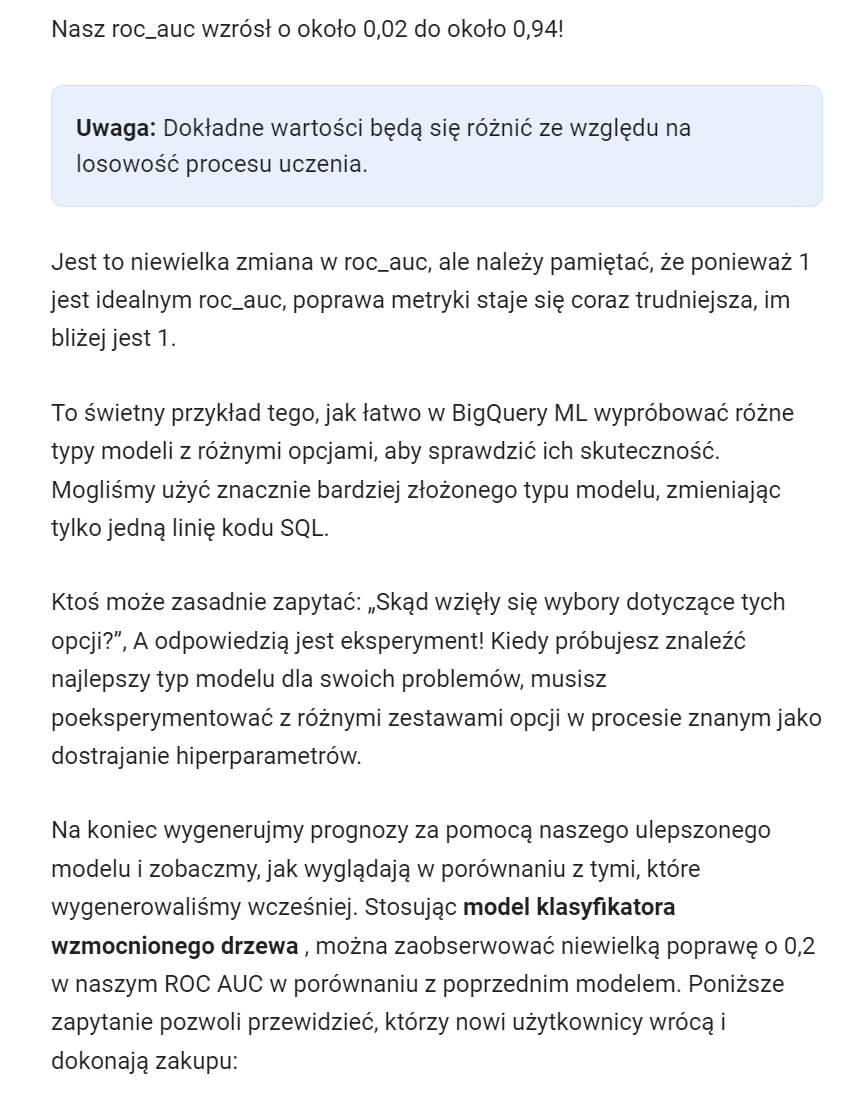

In [ ]:
%%bigquery

SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_3`,
   (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
)
ORDER BY
  predicted_will_buy_on_return_visit DESC;

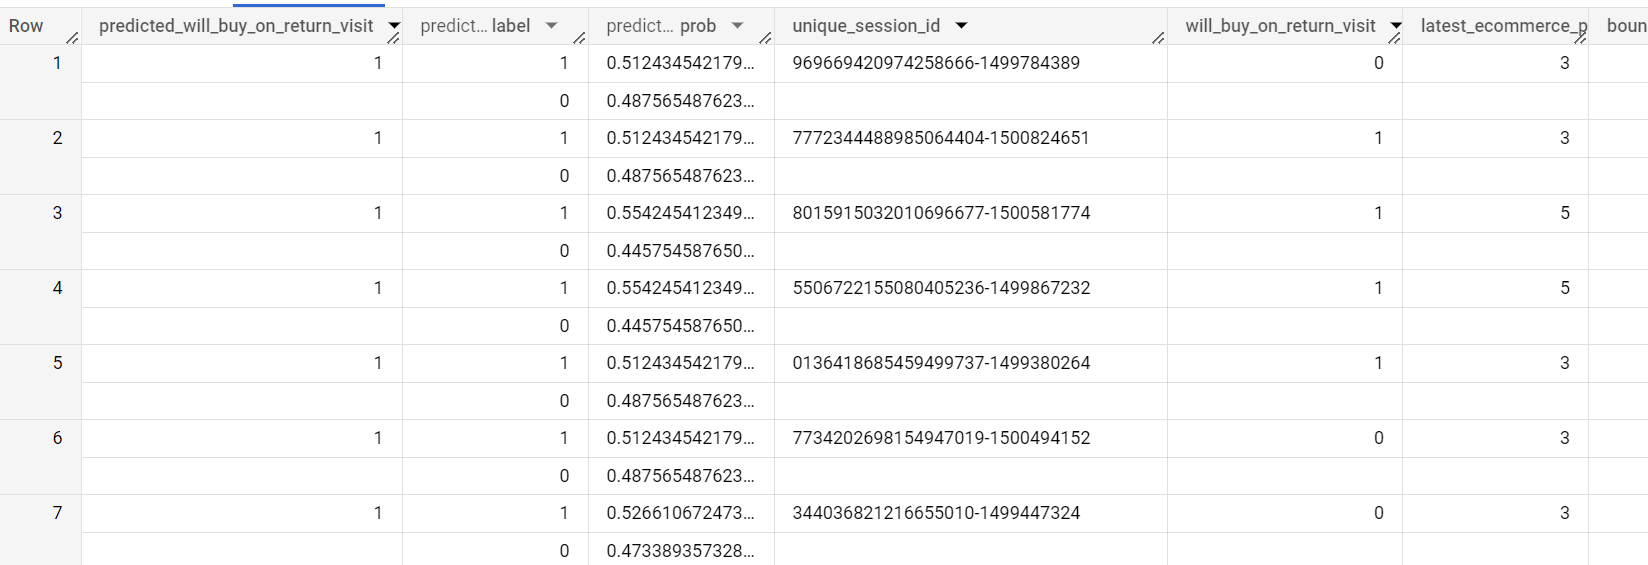

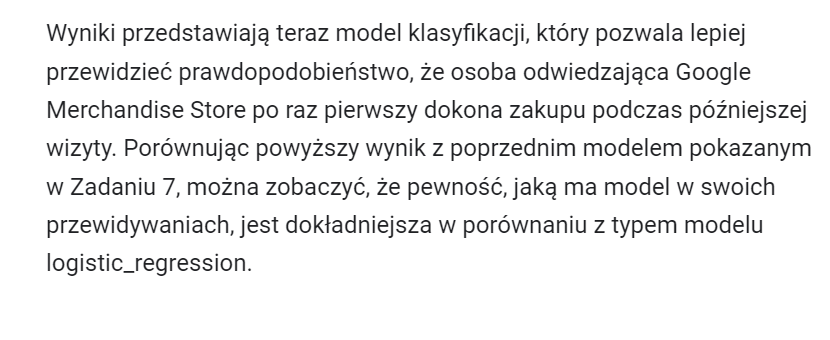